In [157]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
cg = CoinGeckoAPI()

In [158]:
bitcoin = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='idr', days=365)
bitcoin

{'prices': [[1703376000000, 676706098.8903182],
  [1703462400000, 665899707.020366],
  [1703548800000, 674978999.9681069],
  [1703635200000, 655028268.4471744],
  [1703721600000, 667820933.0269203],
  [1703808000000, 658640780.7896981],
  [1703894400000, 647533950.6044563],
  [1703980800000, 649779431.5258198],
  [1704067200000, 649885162.0865278],
  [1704153600000, 679756003.4660023],
  [1704240000000, 697594709.0087506],
  [1704326400000, 666389100.9892768],
  [1704412800000, 685785222.1116412],
  [1704499200000, 683910126.7694162],
  [1704585600000, 681467124.1210266],
  [1704672000000, 680498061.0441318],
  [1704758400000, 727839429.4977998],
  [1704844800000, 716283318.5965112],
  [1704931200000, 725687012.992637],
  [1705017600000, 720790166.2080516],
  [1705104000000, 666477393.1476485],
  [1705190400000, 665771120.9649532],
  [1705276800000, 649589924.4399625],
  [1705363200000, 662515338.0845094],
  [1705449600000, 674400844.5660954],
  [1705536000000, 667942671.9019806],
  [1

In [159]:
bitcoin_df = pd.DataFrame(bitcoin['prices'], columns=['timestamp', 'price'])

In [160]:
bitcoin_df.to_csv('bitcoin.csv', index=False)

In [161]:
bitcoin_df['timestamp'] = pd.to_datetime(bitcoin_df['timestamp'], unit='ms')

In [162]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  366 non-null    datetime64[ns]
 1   price      366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [163]:
# bitcoin_df['price'] = bitcoin_df['price'].apply(lambda x: '{:,.2f}'.format(x))
# bitcoin_df

In [164]:
bitcoin_df.rename(columns={'price': 'price_idr'}, inplace=True)

In [165]:
candlestick_btc = bitcoin_df.groupby(bitcoin_df.timestamp.dt.date).agg({'price_idr': ['min', 'max', 'first', 'last']})

In [166]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=candlestick_btc.index, 
                                     open=candlestick_btc['price_idr']['first'], 
                                     high=candlestick_btc['price_idr']['max'], 
                                     low=candlestick_btc['price_idr']['min'], 
                                     close=candlestick_btc['price_idr']['last']
                                    )
                     ])
fig.update_layout(xaxis_rangeslider_visible=False, title='Candlestick Chart Bitcoin Last 30 Days', xaxis_title='Date', yaxis_title='Price (IDR)')

### Learn how to do time series in this link: https://github.com/salesforce/Merlion?tab=readme-ov-file#installation

## Anomaly Detection

In [167]:
# bitcoin_df['price_idr'] = bitcoin_df['price_idr'].str.replace(',', '').astype(float)
bitcoin_df

,timestamp,price_idr
0,2023-12-24 00:00:00,6.767061e+08
1,2023-12-25 00:00:00,6.658997e+08
2,2023-12-26 00:00:00,6.749790e+08
3,2023-12-27 00:00:00,6.550283e+08
4,2023-12-28 00:00:00,6.678209e+08
...,...,...
361,2024-12-19 00:00:00,1.629776e+09
362,2024-12-20 00:00:00,1.598720e+09
363,2024-12-21 00:00:00,1.579797e+09
364,2024-12-22 00:00:00,1.571896e+09


In [168]:
bitcoin_df.set_index('timestamp', inplace=True)

# Resample to daily frequency and fill missing values
bitcoin_df = bitcoin_df.resample('1D').mean().interpolate()
bitcoin_df.reset_index(inplace=True)

In [169]:
bitcoin_df

,timestamp,price_idr
0,2023-12-24,6.767061e+08
1,2023-12-25,6.658997e+08
2,2023-12-26,6.749790e+08
3,2023-12-27,6.550283e+08
4,2023-12-28,6.678209e+08
...,...,...
360,2024-12-18,1.701935e+09
361,2024-12-19,1.629776e+09
362,2024-12-20,1.598720e+09
363,2024-12-21,1.579797e+09


In [170]:
from merlion.utils import TimeSeries

bitcoin_ts = TimeSeries.from_pd(bitcoin_df.set_index('timestamp'))
print("Time Range:", bitcoin_ts.time_stamps[0], "to", bitcoin_ts.time_stamps[-1])

Time Range: 1703376000.0 to 1734825600.0


In [171]:
from merlion.models.defaults import DefaultDetectorConfig, DefaultDetector

config = DefaultDetectorConfig()
model = DefaultDetector(config)

# Suppose we have 30 days total

split_idx = int(0.8 * len(bitcoin_ts))  # 80% train, 20% test

train_data = bitcoin_ts[:split_idx]
test_data = bitcoin_ts[split_idx:]

df_test = test_data.to_pd().copy()  
# shape [N x 1], index is Timestamps, the single column is "value"

# 2. Create a new column “is_anomaly” (default = 0)
df_test["is_anomaly"] = 0

# 3. Optionally label 1 random point in the test set as anomaly
df_test["is_anomaly"].iloc[-1] = 1  # label the last point as anomaly
test_labels = TimeSeries.from_pd(df_test[["is_anomaly"]])

print("Training window:", train_data.time_stamps[0], "to", train_data.time_stamps[-1])
print("Testing window: ", test_data.time_stamps[0], "to", test_data.time_stamps[-1])

model.train(train_data=train_data)

bitcoin_anomalies = model.get_anomaly_label(time_series=test_data)
print(bitcoin_anomalies)

Training window: 1703376000.0 to 1728518400.0
Testing window:  1728604800.0 to 1734825600.0


C:\Users\lyona\AppData\Local\Temp\ipykernel_11320\1319687192.py:20: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\lyona\AppData\Local\Temp\ipykernel_11320\1319687192.py:20: SettingWithCopyWarning:


A value is trying to be set on a 

            anom_score
time                  
2024-10-11    0.000000
2024-10-12    0.000000
2024-10-13    0.000000
2024-10-14    0.000000
2024-10-15    0.000000
...                ...
2024-12-18    3.049389
2024-12-19    3.071493
2024-12-20    3.031178
2024-12-21    0.000000
2024-12-22    0.000000

[73 rows x 1 columns]


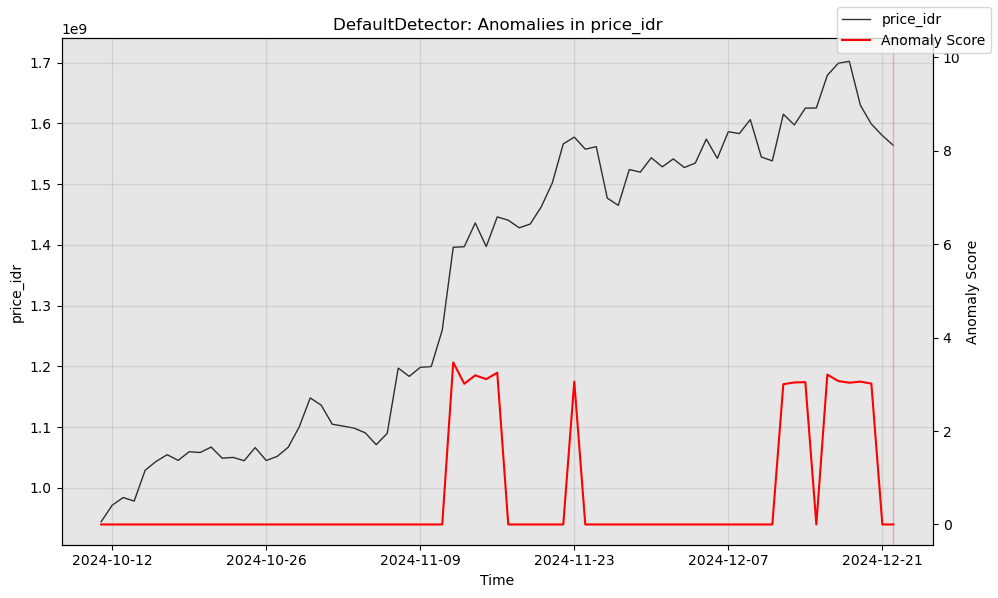

In [172]:
from merlion.plot import plot_anoms
import matplotlib.pyplot as plt

fig, ax = model.plot_anomaly(time_series=test_data)
plot_anoms(ax=ax, anomaly_labels=test_labels)
plt.show()

In [173]:
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster
model2 = DefaultForecaster(DefaultForecasterConfig())
model2.train(train_data=train_data)
test_pred, test_err = model2.forecast(time_stamps=test_data.time_stamps)

Inferred granularity <Day>
c:\Users\lyona\anaconda3\envs\ds-projects\lib\site-packages\merlion\models\forecast\ets.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\lyona\anaconda3\envs\ds-projects\lib\site-packages\merlion\models\forecast\ets.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\lyona\anaconda3\envs\ds-projects\lib\site-packages\merlion\models\forecast\ets.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

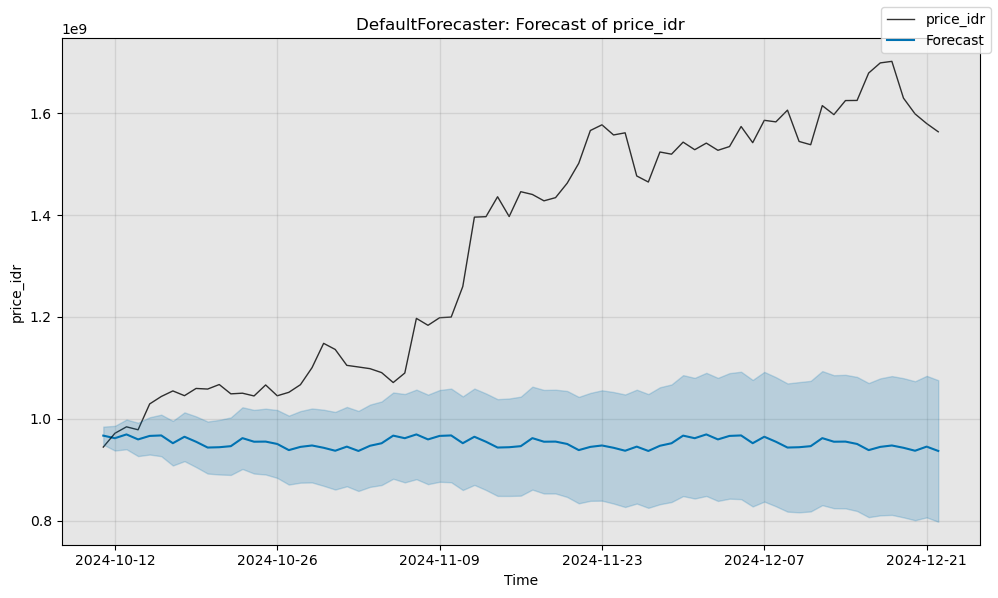

In [174]:
import matplotlib.pyplot as plt
fig, ax = model2.plot_forecast(time_series=test_data, plot_forecast_uncertainty=True)
plt.show()

In [175]:
# Evaluate the model's predictions quantitatively
from scipy.stats import norm
from merlion.evaluate.forecast import ForecastMetric

# Compute the sMAPE of the predictions (0 to 100, smaller is better)
smape = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=test_pred)

# Compute the MSIS of the model's 95% confidence interval (0 to 100, smaller is better)
lb = TimeSeries.from_pd(test_pred.to_pd() + norm.ppf(0.025) * test_err.to_pd().values)
ub = TimeSeries.from_pd(test_pred.to_pd() + norm.ppf(0.975) * test_err.to_pd().values)
msis = ForecastMetric.MSIS.value(ground_truth=test_data, predict=test_pred,
                                 insample=train_data, lb=lb, ub=ub)
print(f"sMAPE: {smape:.4f}, MSIS: {msis:.4f}")

sMAPE: 31.9080, MSIS: 709.2596
